In [1]:
!pip install datasets evaluate rouge_score loralib peft --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType
import os

os.environ["WANDB_DISABLED"]='true'
DASH_LINE = '-'*100  # ターミナル出力の区切り
LOGGING_STEPS = 50
MAX_STEPS = 300


llm_model_name = 'google/flan-t5-base'
#llm_model_name = 'google/flan-t5-small' # 時間切れの心配がないが性能が低い

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [3]:
dataset = load_dataset('knkarthick/dialogsum')
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


In [4]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    print(f"訓練可能パラメータ: {trainable_model_params:,}")
    print(f"全パラメータ: {all_model_params:,}")
    print(f"訓練可能パラメータ割合: {100 * trainable_model_params / all_model_params:.2f}%")


def load_model(model_name):
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print_number_of_trainable_model_parameters(model)
    model = model.to(device)
    return model, tokenizer

original_model, tokenizer = load_model(llm_model_name)


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

訓練可能パラメータ: 247,577,856
全パラメータ: 247,577,856
訓練可能パラメータ割合: 100.00%


In [5]:
def get_summary_prompt(dialogue, tokenizer):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
    """

    return tokenizer(prompt, return_tensors="pt").input_ids, prompt

def show_dialogue(index, tokenizer, model):
    input_ids, prompt = get_summary_prompt(dataset['test'][index]['dialogue'], tokenizer)
    print(f"Model device: {original_model.device}")
    print(f"Input device: {input_ids.device}")
    output = tokenizer.decode(
    model.generate(
        input_ids.to(model.device),
        max_new_tokens=200,
        )[0],
    skip_special_tokens=True
    )

    print(DASH_LINE)
    print(f'プロンプト:\n{prompt}')
    print(DASH_LINE)
    print(f"要約正解ラベル:\n{dataset['test'][index]['summary']}\n")
    print(DASH_LINE)
    print(f'モデル生成結果 Zero Shot:\n{output}')
show_dialogue(200, tokenizer, original_model)


Model device: cuda:0
Input device: cpu
----------------------------------------------------------------------------------------------------
プロンプト:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:
    
------------------------------

In [6]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example


def edit_datasets(dataset):

    # プロンプト化とTokenize
    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # 不要列削除
    tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

    # 1/10に削減
    tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 10 == 0, with_indices=True)

    print(f"Shapes of the datasets:")
    print(f"Training: {tokenized_datasets['train'].shape}")
    print(f"Validation: {tokenized_datasets['validation'].shape}")
    print(f"Test: {tokenized_datasets['test'].shape}")
    print(tokenized_datasets)

    return tokenized_datasets

tokenized_datasets = edit_datasets(dataset)


Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Shapes of the datasets:
Training: (1246, 2)
Validation: (50, 2)
Test: (150, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1246
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 50
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 150
    })
})


In [7]:
### フルファインチューニング
%%time
def full_fine_tune(model, datasets):
    output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=1e-5,
        num_train_epochs=20,
        weight_decay=0.01,
        logging_steps=LOGGING_STEPS,
        max_steps=MAX_STEPS
    )

    trainer = Trainer(
        model=original_model,
        args=training_args,
        train_dataset=datasets['train'],
        eval_dataset=datasets['validation']
    )

    trainer.train()
    return trainer.model

instruct_model = full_fine_tune(original_model, tokenized_datasets)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,47.565000
100,45.770000
150,44.770000
200,44.080000
250,43.660000
300,43.330000


CPU times: user 9min 12s, sys: 4min 52s, total: 14min 4s
Wall time: 14min 49s


In [8]:
### PEFT/LoRaでファインチューニング
%%time
def peft_fine_tune(model, datasets):
    output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

    print("config")
    lora_config = LoraConfig(
        r=32, # Rank
        lora_alpha=32,
        target_modules=["q", "v"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
    )

    print("args")
    peft_training_args = TrainingArguments(
        output_dir=output_dir,
        auto_find_batch_size=True,
        learning_rate=1e-3, # Higher learning rate than full fine-tuning.
        num_train_epochs=20,
        logging_steps=LOGGING_STEPS,
        max_steps=MAX_STEPS
    )

    print("get_peft")
    peft_model = get_peft_model(model, lora_config)
    print_number_of_trainable_model_parameters(peft_model)

    print("trainer")
    peft_trainer = Trainer(
        model=peft_model,
        args=peft_training_args,
        train_dataset=datasets["train"],
        eval_dataset=datasets['validation']
    )

    peft_trainer.train()
    print("complete.")

    return peft_trainer.model

peft_model = peft_fine_tune(original_model, tokenized_datasets)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


config
args
get_peft
訓練可能パラメータ: 3,538,944
全パラメータ: 251,116,800
訓練可能パラメータ割合: 1.41%
trainer


Step,Training Loss
50,9.007800
100,0.546100
150,0.229400
200,0.199400
250,0.168700
300,0.170900


complete.
CPU times: user 7min 26s, sys: 4min 11s, total: 11min 38s
Wall time: 11min 42s


In [9]:
### 訓練済モデルでテスト実施
def get_three_outputs(input_ids, model1, model2, model3):
    config = GenerationConfig(max_new_tokens=200, num_beams=1)
    model1_outputs = model1.generate(input_ids=input_ids.to(model1.device), generation_config=config)
    model1_text_output = tokenizer.decode(model1_outputs[0], skip_special_tokens=True)

    model2_outputs = model2.generate(input_ids=input_ids.to(model2.device), generation_config=config)
    model2_text_output = tokenizer.decode(model2_outputs[0], skip_special_tokens=True)

    model3_outputs = model3.generate(input_ids=input_ids.to(model3.device), generation_config=config)
    model3_text_output = tokenizer.decode(model3_outputs[0], skip_special_tokens=True)
    return model1_text_output, model2_text_output, model3_text_output

def show_result(dataset, tokenizer, original_model, instruct_model, peft_model):
    input_ids, _ = get_summary_prompt(dataset['dialogue'], tokenizer)
    print(input_ids.device)
    original_model_text_output, instruct_model_text_output, peft_model_text_output = \
      get_three_outputs(input_ids, original_model, instruct_model, peft_model)

    print(DASH_LINE)
    print(f"要約正解ラベル:\n{dataset['summary']}")
    print(DASH_LINE)
    print(f'訓練前モデル:\n{original_model_text_output}')
    print(DASH_LINE)
    print(f'訓練後モデル:\n{instruct_model_text_output}')
    print(DASH_LINE)
    print(f'PEFTモデル:\n{peft_model_text_output}')

show_result(dataset['test'][200], tokenizer, original_model, instruct_model, peft_model)

cpu
----------------------------------------------------------------------------------------------------
要約正解ラベル:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
----------------------------------------------------------------------------------------------------
訓練前モデル:
#Person1# wants to upgrade their computer hardware.
----------------------------------------------------------------------------------------------------
訓練後モデル:
#Person1# asks #Person2# to upgrade his computer. #Person2# suggests adding a painting program to his computer. #Person2# asks #Person2# to consider a painting program.
----------------------------------------------------------------------------------------------------
PEFTモデル:
#Person2# suggests that you could add a painting program to your computer.


,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,#Person1#'s memo is a memo that should go out ...,#Person1# asks #Person2# to take a dictation f...,#Person1# wants to have an intra-office memora...
1,In order to prevent employees from wasting tim...,#Person2# asks #Person2# to take a dictamic fo...,#Person1#'s office communications are restrict...,#Person2# asks #Person2# to take a dictation f...
2,Ms. Dawson takes a dictation for #Person1# abo...,#Person2# asks #Person2# to type up a memo to ...,#Person1# asks #Person1# to take a dictation f...,#Person1# asks #Person2# to take a dictation f...
3,#Person2# arrives late because of traffic jam....,#Person2# is stuck in traffic at the Carrefour...,#Person2# is finally here and asks #Person1# t...,#Person2# thinks it would be better to take th...
4,#Person2# decides to follow #Person1#'s sugges...,The traffic jam isn't good enough to avoid. #P...,#Person2# is stuck in traffic and is stuck in ...,#Person1# thinks that #Person2#'s car is addin...
5,#Person2# complains to #Person1# about the tra...,#Person1# tells #Person2# to take public trans...,#Person2# is driving to work and #Person2# is ...,#Person2# thinks it's good to take the subway ...
6,#Person1# tells Kate that Masha and Hero get d...,#Person1# thinks Masha and Masha are getting d...,#Person1# tells #Person2# that Masha and Hero ...,#Person2# is getting divorced. #Person2# think...
7,#Person1# tells Kate that Masha and Hero are g...,#Person2# is a snobber and wants to divorce Ma...,#Person1# is getting divorced. #Person2# think...,#Person1# is surprised by Masha and Hero's div...
8,#Person1# and Kate talk about the divorce betw...,#Person1# and Masha are getting divorced. #Per...,#Person1# tells #Person1# that Masha and Hero ...,#Person1# isn't really sure what's going to ha...
9,#Person1# and Brian are at the birthday party ...,Brian's birthday is on Friday. Brian is invite...,@Person1# and Brian are having a good time at ...,#Person1# is celebrating his birthday.


Original Model:
{'rouge1': np.float64(0.3523774017892378), 'rouge2': np.float64(0.1051858890959397), 'rougeL': np.float64(0.2711901213113922), 'rougeLsum': np.float64(0.27439869464032696)}
Fine Tuned(Full-Tune):
{'rouge1': np.float64(0.34927892382797643), 'rouge2': np.float64(0.10943141825494768), 'rougeL': np.float64(0.2977172159600018), 'rougeLsum': np.float64(0.3001731781539685)}
Fine Tuned(PEFT):
{'rouge1': np.float64(0.31009185055501126), 'rouge2': np.float64(0.09002592282947754), 'rougeL': np.float64(0.23316988634888614), 'rougeLsum': np.float64(0.2321029867483818)}
モデル改善率(訓練済モデル(Full-Tune):訓練前モデル)
rouge1: -0.31%
rouge2: 0.42%
rougeL: 2.65%
rougeLsum: 2.58%
モデル改善率(訓練済モデル(PEFT):訓練前モデル)
rouge1: -4.23%
rouge2: -1.52%
rougeL: -3.80%
rougeLsum: -4.23%
モデル改善率(訓練済モデル(PEFT):訓練済モデル(Full-Tune):)
rouge1: -3.92%
rouge2: -1.94%
rougeL: -6.45%
rougeLsum: -6.81%


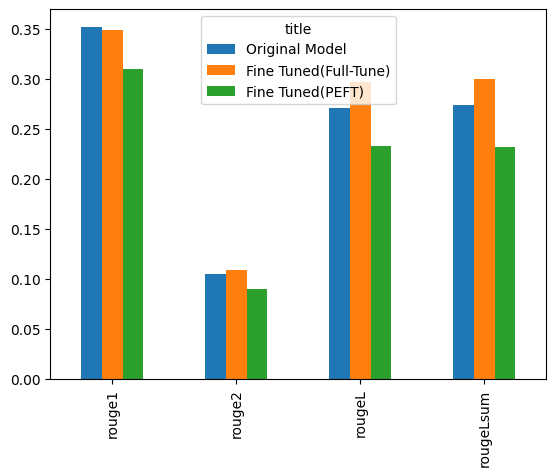

In [10]:
### ROUGE での評価
def rouge_compute(rouge, title, human_baseline_summaries, predictions):
    model_results = rouge.compute(
      predictions=predictions,
      references=human_baseline_summaries[0:len(predictions)],
      use_aggregator=True,
      use_stemmer=True,
    )
    print(f'{title}:')
    print(model_results)
    model_results['title'] = title  # ← このままでOK（可視化に使う）
    return model_results

def show_summaries(dataset, tokenizer, original_model, instruct_model, peft_model):
    rouge = evaluate.load('rouge')
    human_baseline_summaries = dataset['summary']
    original_model_summaries = []
    instruct_model_summaries = []
    peft_model_summaries = []

    for dialogue in dataset['dialogue']:
        input_ids, _ = get_summary_prompt(dialogue, tokenizer)
        original_model_text_output, instruct_model_text_output, peft_model_text_output = \
          get_three_outputs(input_ids, original_model, instruct_model, peft_model)

        original_model_summaries.append(original_model_text_output)
        instruct_model_summaries.append(instruct_model_text_output)
        if peft_model:
            peft_model_summaries.append(peft_model_text_output)

    zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))
    df = pd.DataFrame(zipped_summaries,
                          columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
    display(df[0:10])

    original_model_results = rouge_compute(rouge, 'Original Model', human_baseline_summaries, original_model_summaries)
    instruct_model_results = rouge_compute(rouge, 'Fine Tuned(Full-Tune)', human_baseline_summaries, instruct_model_summaries)
    peft_model_results = rouge_compute(rouge, 'Fine Tuned(PEFT)', human_baseline_summaries, peft_model_summaries)

    model_results = []
    model_results.append(original_model_results)
    model_results.append(instruct_model_results)
    model_results.append(peft_model_results)
    pd.DataFrame(model_results).set_index('title').transpose().plot(kind='bar')

    # ここから：数値キーのみを使って改善率を計算（'title'を除外）
    metric_keys = [k for k in original_model_results.keys() if k != 'title']

    print("モデル改善率(訓練済モデル(Full-Tune):訓練前モデル)")
    improvement = (
        np.array([instruct_model_results[k] for k in metric_keys]) -
        np.array([original_model_results[k] for k in metric_keys])
    )
    for key, value in zip(metric_keys, improvement):
        print(f'{key}: {value*100:.2f}%')

    print("モデル改善率(訓練済モデル(PEFT):訓練前モデル)")
    improvement = (
        np.array([peft_model_results[k] for k in metric_keys]) -
        np.array([original_model_results[k] for k in metric_keys])
    )
    for key, value in zip(metric_keys, improvement):
        print(f'{key}: {value*100:.2f}%')

    print("モデル改善率(訓練済モデル(PEFT):訓練済モデル(Full-Tune):)")
    improvement = (
        np.array([peft_model_results[k] for k in metric_keys]) -
        np.array([instruct_model_results[k] for k in metric_keys])
    )
    for key, value in zip(metric_keys, improvement):
        print(f'{key}: {value*100:.2f}%')

show_summaries(dataset['test'][0:10], tokenizer, original_model, instruct_model, peft_model)